Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [608]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part one of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [609]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

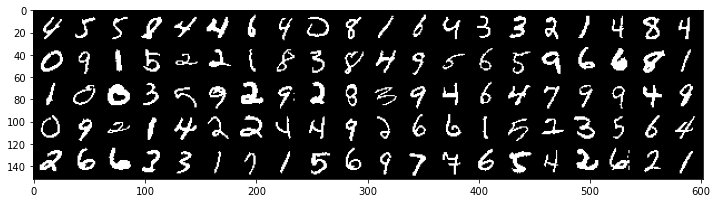

In [610]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 extra credit points if you do something "interesting": this would in particular mean architectures which perform better than a feed-forward network, while having fewer parameters.



In [611]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        #
        # Later on in the `.forward` method, you then can call this.
        #
        # Some ``useful'' layers include:
        #
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.dropOut = nn.Dropout(p=0.25)
        self.encConv1 = nn.Conv2d(1, 4, 4, 2, padding=1)
        self.encConv1_bn=nn.BatchNorm2d(4)
        self.encConv2 = nn.Conv2d(4, 8, 4, 2, padding=1)
        self.encConv2_bn=nn.BatchNorm2d(8)
        self.encFC1 = nn.Linear(8*7*7, D_latent)
        self.encFC2 = nn.Linear(8*7*7, D_latent)

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        x = self.dropOut(X)
        x = self.LeakyReLU(self.encConv1_bn(self.encConv1(x)))
        x = self.LeakyReLU(self.encConv2_bn(self.encConv2(x)))
        x = x.view(-1, 8*7*7)
        
        mu = self.encFC1(x)
        sigma = torch.exp(self.encFC2(x) / 2)

        assert mu.shape == (X.shape[0], self.D_latent)
        assert mu.shape == sigma.shape
        return dist.Normal(mu, sigma)
        


In [612]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.decFC1 = nn.Linear(D_latent, 8*7*7)
        self.decConv1 = nn.ConvTranspose2d(8, 8, 4, 2, padding=1)
        self.decConv1_bn = nn.BatchNorm2d(8)
        self.decConv2 = nn.ConvTranspose2d(8, 1, 4, 2, padding=1)

    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """
        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        x = self.LeakyReLU(self.decFC1(Z))
        x = x.view(-1, 8, 7, 7)
        x = self.LeakyReLU(self.decConv1_bn(self.decConv1(x)))

        X_hat = torch.sigmoid(self.decConv2(x))

        return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))



In [613]:
class Encoder2(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        #
        # Later on in the `.forward` method, you then can call this.
        #
        # Some ``useful'' layers include:
        #
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...


        hidden_dim = 196
        hidden_dim_2 = 49
        self.FC_input = nn.Linear(784, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim_2)
        self.FC_input3 = nn.Linear(hidden_dim_2, hidden_dim_2)
        self.FC_mu  = nn.Linear(hidden_dim_2, D_latent)
        self.FC_var   = nn.Linear (hidden_dim_2, D_latent)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.softplus = nn.Softplus()


    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        X = X.reshape(-1,784)
        h_       = self.softplus(self.FC_input(X))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        h_       = self.LeakyReLU(self.FC_input3(h_))
        mu     = self.FC_mu(h_)
        sigma  = torch.exp(self.FC_var(h_) / 2) 


class Decoder2(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        hidden_dim = 196
        hidden_dim_2 = 49
        # Define your networks here
        self.FC_hidden = nn.Linear(D_latent, hidden_dim_2)
        self.FC_hidden2 = nn.Linear(hidden_dim_2, hidden_dim)
        self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, 784)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.softplus = nn.Softplus()

        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """

        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        # YOUR CODE HERE
        h     = self.softplus(self.FC_hidden(Z))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        h     = self.LeakyReLU(self.FC_hidden3(h))
        
        X_hat = torch.sigmoid(self.FC_output(h))
        return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))




# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a Monte Carlo estimate of

$$ELBO(X) = \mathbb{E}_{q(Z | X)}\left[ \log \left [ \frac{p(Z)p(X | Z)}{q(Z | X)} \right ] \right ]$$

where $q(Z | X)$ and $p(X | Z)$ are returned by the `Encoder` and `Decoder` classes you defined above.


In [614]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28).
    
    """
    N_samples = 2
    q = enc(X)
    sum = 0
    for i in range(N_samples):
      z = q.rsample()

      p = dec(z)
      prior = dist.Normal(0, 1)
      log_prior = prior.log_prob(z).sum(axis=1)
      log_likeli = p.log_prob(X).reshape(X.shape[0], -1).sum(axis=1)
      log_var = q.log_prob(z).sum(axis=1)
      sum += log_likeli + log_prior - log_var

    return sum/N_samples
    
    # YOUR CODE HERE
    

# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [615]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [616]:
enc2 = Encoder2(2)
dec2 = Decoder2(2)
pytorch_total_params = sum(p.numel() for p in enc2.parameters())
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in dec2.parameters())
print(pytorch_total_params)


pytorch_total_params = sum(p.numel() for p in enc.parameters())
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in dec.parameters())
print(pytorch_total_params)

166163
203007
8472
5489


In [617]:
N_epochs = 10 # Note that you may want to run more than 10 epochs!
for epoch in range(N_epochs):
    train_loss = 0.0
    for (X, _) in train_loader:
        opt_vae.zero_grad()
        loss = -ELBO_VAE(enc, dec, X).mean()
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
    print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

Epoch 0, train loss = 203.3016
Epoch 1, train loss = 124.2377
Epoch 2, train loss = 116.8976
Epoch 3, train loss = 113.4987
Epoch 4, train loss = 111.5652
Epoch 5, train loss = 110.2546
Epoch 6, train loss = 109.2234
Epoch 7, train loss = 108.4099
Epoch 8, train loss = 107.9582
Epoch 9, train loss = 107.3647


## Do reconstructions look like the input?

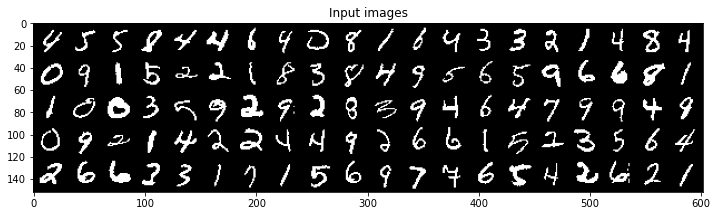

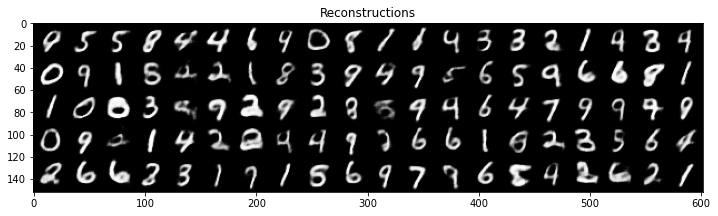

In [618]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean, nrow=20).permute(1,2,0))

## Do randomly generated samples look coherent?

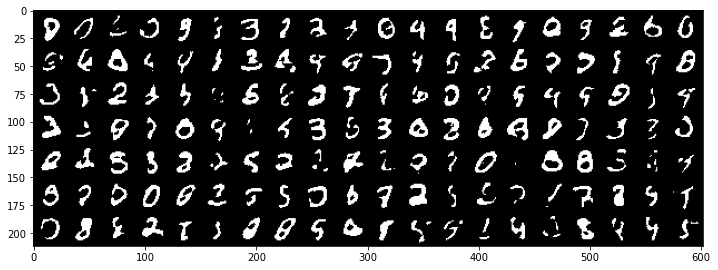

In [619]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

In [630]:
print((X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

0.9279719591140747


## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

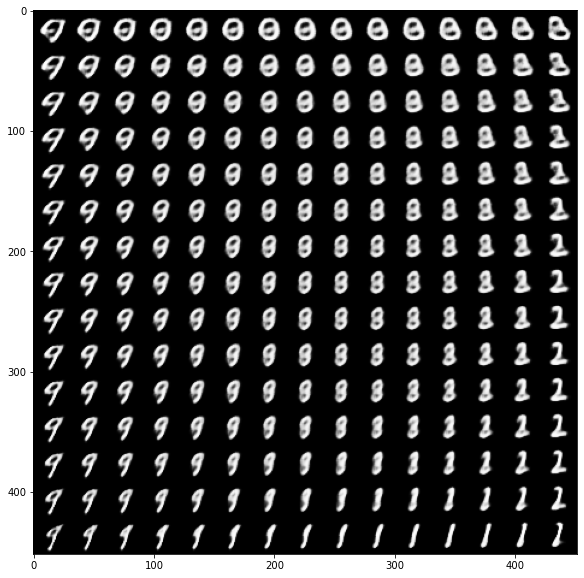

In [621]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [622]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [623]:
# grading


In [624]:
# grading


In [625]:
# grading


In [626]:
# grading


In [627]:
# grading


In [628]:
# grading


In [629]:
# grading
